# Analyse A/B Test Results For Art Gallery Website

## Table of Contents
### 1. Introduction
### 2. Part I - Probability
### 3. Part II - A/B Test
### 4. Part III - Regression
### 5. Summary & Conclusions

### Introduction
#### A/B testing is a common technique used to analyse which web designs or features drive more engagement.
#### Many companies use A/B testing to test feature changes, layouts, and even colours to increase user engagement.
#### In this project, I analyse the results of an A/B test conducted by an art gallery to determine whether a new landing page design increases email sign-ups compared to the current design.
#### Part I - Probability

In [33]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

random.seed(42)

df = pd.read_csv('AB_Test-Landing_page.csv')

print(df.head())

print(df.dtypes)

df['variant_id'] = df['variant_id'].astype(int)
df['converted'] = df['converted'].astype(int)



   user_id   timestamp experiment_id  variant_id  converted       location  \
0    10001  15/07/2024     exp_12345           0          1           Asia   
1    10002  19/04/2024     exp_12345           1          0          Other   
2    10003  19/02/2024     exp_12345           1          0  North America   
3    10004  07/05/2024     exp_12345           1          0           Asia   
4    10005  20/02/2024     exp_12345           0          0           Asia   

   device  
0  Tablet  
1  Tablet  
2  Tablet  
3  Tablet  
4  Tablet  
user_id           int64
timestamp        object
experiment_id    object
variant_id        int64
converted         int64
location         object
device           object
dtype: object


Number of rows: 5000
Number of columns: 7
5000 unique users
Proportion of users converted = 22.74000%
Probability of conversion for control group: 22.16000%
Probability of conversion for treatment group: 23.32000%
Probability of receiving the new page: 0.50000

Conversion Rate by Location:
 location
Asia             0.282051
Europe           0.220161
North America    0.210811
Other            0.199045
Name: converted, dtype: float64


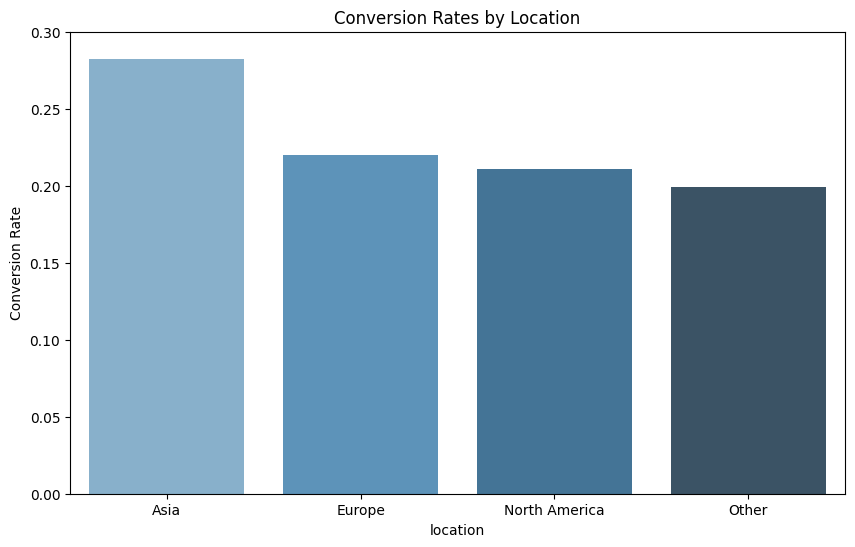


Conversion Rate by Device Type:
 device
Desktop    0.238833
Mobile     0.211098
Tablet     0.232111
Name: converted, dtype: float64


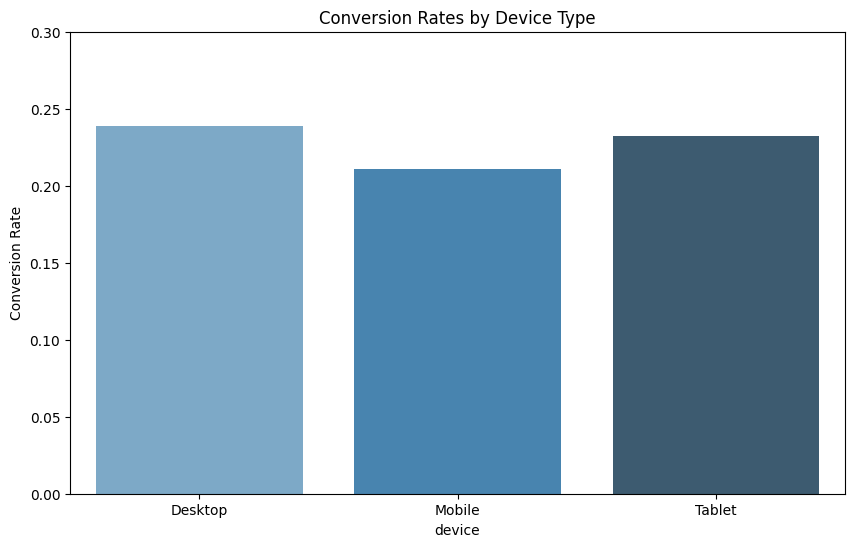

In [34]:
# Part I - Probability

print('Number of rows: {}'.format(df.shape[0]))
print('Number of columns: {}'.format(df.shape[1]))

print('{} unique users'.format(df['user_id'].nunique()))

# Proportion of converted
overall_conversion_rate = df['converted'].mean()
print('Proportion of users converted = {:.5f}%'.format(overall_conversion_rate * 100))

control_conversion_rate = df.query('variant_id == 0')['converted'].mean()
print('Probability of conversion for control group: {:.5f}%'.format(control_conversion_rate * 100))

treatment_conversion_rate = df.query('variant_id == 1')['converted'].mean()
print('Probability of conversion for treatment group: {:.5f}%'.format(treatment_conversion_rate * 100))

# Probability of receiving the new page (treatment)
prob_new_page = (df['variant_id'] == 1).mean()
print('Probability of receiving the new page: {:.5f}'.format(prob_new_page))

conversion_rate_by_location = df.groupby('location')['converted'].mean()
print('\nConversion Rate by Location:\n', conversion_rate_by_location)
plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_rate_by_location.index, y=conversion_rate_by_location.values, hue=conversion_rate_by_location.index, palette='Blues_d', legend=False)
plt.title('Conversion Rates by Location')
plt.ylabel('Conversion Rate')
plt.ylim(0, 0.30)
plt.show()


conversion_rate_by_device = df.groupby('device')['converted'].mean()
print('\nConversion Rate by Device Type:\n', conversion_rate_by_device)
plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_rate_by_device.index, y=conversion_rate_by_device.values, hue=conversion_rate_by_device.index, palette='Blues_d', legend=False)
plt.title('Conversion Rates by Device Type')
plt.title('Conversion Rates by Device Type')
plt.ylabel('Conversion Rate')
plt.ylim(0, 0.30)
plt.show()

Summary of Conversion Analysis

Overall Conversion Statistics
- **Total Number of Rows:** 5,000
- **Number of Unique Users:** 5,000
- **Proportion of Users Converted:** 22.74%
- **Probability of Conversion for Control Group:** 22.16%
- **Probability of Conversion for Treatment Group:** 23.32%
- **Probability of Receiving the New Page:** 50%

Conversion Rate by Location
- **Asia:** 28.21%
- **Europe:** 22.02%
- **North America:** 21.08%
- **Other Regions:** 19.90%

Conversion Rate by Device Type
- **Desktop:** 23.88%
- **Mobile:** 21.11%
- **Tablet:** 23.21%

Insights
The overall conversion rate for the entire user base is 22.74%. The conversion rate is slightly higher in the treatment group (23.32%) compared to the control group (22.16%). 

When analysing conversion rates by location, users in Asia have the highest conversion rate at 28.21%, followed by Europe (22.02%). North America and other regions have lower conversion rates, at 21.08% and 19.90%, respectively.

Conversion rates also vary by device type, with Desktop users converting at the highest rate (23.88%), followed by Tablet users (23.21%). Mobile users have the lowest conversion rate at 21.11%.


### Part II - A/B Test

#### Hypothesis Setup

##### Before diving into the analysis, it's important to establish my hypotheses. I will use a two-tailed test to determine if the new page has a different conversion rate compared to the old page.

- **Null Hypothesis (H0):** The new page is not better than the old page, meaning the conversion rates are the same or the new page performs worse,  

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>H</mi>
    <mn>0</mn>
  </msub>
  <mo>:</mo>
  <msub>
    <mi>p</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>n</mi>
      <mi>e</mi>
      <mi>w</mi>
    </mrow>
  </msub>
  <mo>&#x2212;</mo>
  <msub>
    <mi>p</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>o</mi>
      <mi>l</mi>
      <mi>d</mi>
    </mrow>
  </msub>
  <mo>&#x2264;</mo>
  <mn>0</mn>
</math>

- **Alternative Hypothesis (H1):** The new page has a higher conversion rate than the old page, 

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>H</mi>
    <mn>1</mn>
  </msub>
  <mo>:</mo>
  <msub>
    <mi>p</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>n</mi>
      <mi>e</mi>
      <mi>w</mi>
    </mrow>
  </msub>
  <mo>&#x2212;</mo>
  <msub>
    <mi>p</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>o</mi>
      <mi>l</mi>
      <mi>d</mi>
    </mrow>
  </msub>
  <mo>&gt;</mo>
  <mn>0</mn>
</math>

Given that I am assuming the old page is better unless proven otherwise, my hypothesis test will be one-tailed with a Type I error rate (alpha) of 5%.

### Simulation under the Null Hypothesis

To understand the distribution of conversion differences under the null hypothesis, I perform a simulation:

1. **Assumption under the Null Hypothesis:** The "true" success rates for both the old and new pages are equal to the overall conversion rate observed in the data.

2. **Simulation Process:**
   - I will generate simulated conversion rates for both the new and old pages based on the null hypothesis using a binomial distribution.
   - The difference between the simulated conversion rates will be calculated for 10,000 iterations.

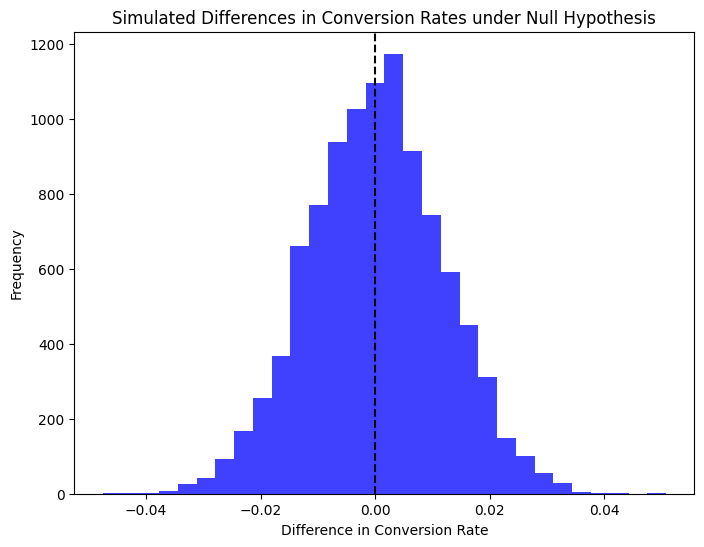

P-value: 0.16190
Z-Score: -0.97845, P-Value: 0.83608


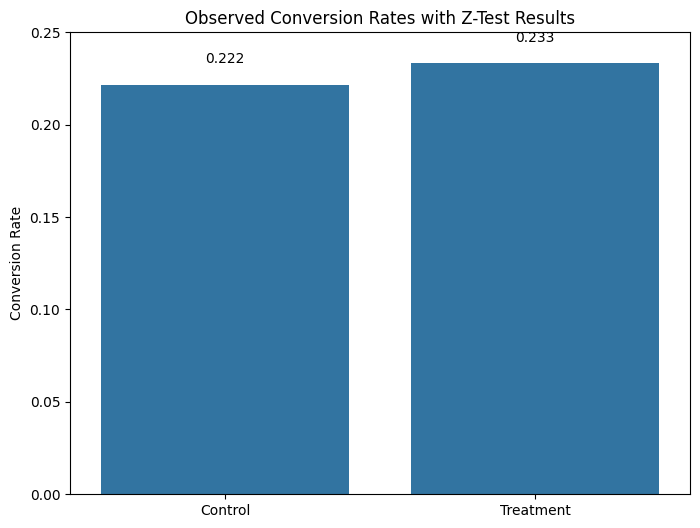

In [35]:
p_new = overall_conversion_rate
p_old = overall_conversion_rate
n_new = df.query('variant_id == 1').shape[0]
n_old = df.query('variant_id == 0').shape[0]

new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old


p_diffs = new_page_converted - old_page_converted
plt.figure(figsize=(8, 6))
plt.hist(p_diffs, bins=30, alpha=0.75, color='blue')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Simulated Differences in Conversion Rates under Null Hypothesis')
plt.xlabel('Difference in Conversion Rate')
plt.ylabel('Frequency')
plt.show()

obs_diff = df.query('variant_id == 1')['converted'].mean() - df.query('variant_id == 0')['converted'].mean()

p_value = (p_diffs > obs_diff).mean()
print('P-value: {:.5f}'.format(p_value))

convert_old = df.query('variant_id == 0')['converted'].sum()
convert_new = df.query('variant_id == 1')['converted'].sum()
n_old = df.query('variant_id == 0').shape[0]
n_new = df.query('variant_id == 1').shape[0]

z_score, p_value = proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')
print('Z-Score: {:.5f}, P-Value: {:.5f}'.format(z_score, p_value))

plt.figure(figsize=(8, 6))
sns.barplot(x=['Control', 'Treatment'], y=[convert_old/n_old, convert_new/n_new])
plt.title('Observed Conversion Rates with Z-Test Results')
plt.ylabel('Conversion Rate')
plt.ylim(0, 0.25)
plt.text(0, convert_old/n_old + 0.01, f'{convert_old/n_old:.3f}', ha='center', va='bottom')
plt.text(1, convert_new/n_new + 0.01, f'{convert_new/n_new:.3f}', ha='center', va='bottom')
plt.show()

Part II - A/B Test Results

Statistical Analysis Summary
- **P-value (Simulated):** 0.16450
- **Z-Score:** -0.97845
- **P-Value (Z-Test):** 0.83608

Interpretation
The P-value obtained from the simulation is 0.16450. This value indicates that there is a 16.45% probability of observing a difference in conversion rates as extreme as the one found in the data, assuming the null hypothesis is true.

The Z-score of -0.97845 and the corresponding P-value of 0.83608 from the Z-test further support the conclusion that there is no statistically significant difference between the conversion rates of the treatment and control groups.

Given that both P-values are greater than the commonly used significance level of 0.05, we fail to reject the null hypothesis. This suggests that the new page does not significantly outperform the old page in terms of conversion rate. The company may consider keeping the current page or running the experiment for a longer duration to gather more data.

Segment Analysis by Location
In Part II, the A/B Test indicated that the new page does not significantly improve conversion rates overall. However, this does not rule out the possibility of regional differences in user behaviour. By incorporating segment analysis into the regression model, therefore, a logistic regression analysis is followed.



### Part III - Regression

In [36]:
# Encode device and location
location_dummies = pd.get_dummies(df['location'], prefix='location', dtype=int)
device_dummies = pd.get_dummies(df['device'], prefix='device',dtype =int)
df = pd.concat([df, location_dummies, device_dummies], axis=1)
df.drop(columns=['location', 'device'], inplace=True)
print(df.head())





   user_id   timestamp experiment_id  variant_id  converted  location_Asia  \
0    10001  15/07/2024     exp_12345           0          1              1   
1    10002  19/04/2024     exp_12345           1          0              0   
2    10003  19/02/2024     exp_12345           1          0              0   
3    10004  07/05/2024     exp_12345           1          0              1   
4    10005  20/02/2024     exp_12345           0          0              1   

   location_Europe  location_North America  location_Other  device_Desktop  \
0                0                       0               0               0   
1                0                       0               1               0   
2                0                       1               0               0   
3                0                       0               0               0   
4                0                       0               0               0   

   device_Mobile  device_Tablet  
0              0            

In [37]:
df['intercept'] = 1
# Calculate VIF for each feature
X = df[['intercept', 'variant_id', 'location_Asia', 'location_Europe', 'location_North America', 'location_Other', 'device_Desktop', 'device_Mobile', 'device_Tablet']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                  feature           VIF
0               intercept  0.000000e+00
1              variant_id  1.000700e+00
2           location_Asia           inf
3         location_Europe  3.309029e+07
4  location_North America  1.633894e+03
5          location_Other  5.930510e+03
6          device_Desktop  3.021797e+07
7           device_Mobile  2.587208e+07
8           device_Tablet  5.808030e+03


c:\miniconda\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\miniconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF has been checked to reduce the multicollinearity issue. However, **location_Asia** shows an infinite VIF (`inf`), suggesting perfect collinearity, while  , **location_Other**, and **device_Tablet** have extremely high VIF values, indicating severe multicollinearity. These variables should be considered for removal to improve the regression model.
In this analysis, I performed two separate logistic regression models to address multicollinearity issues among the predictor variables. Multicollinearity occurs when independent variables in a regression model are highly correlated, leading to unreliable and unstable coefficient estimates. This can distort the interpretation of the relationship between the predictors and the outcome variable.

*Model 1:* The first logistic regression model included a set of location variables (**location_Asia**, **location_Europe**, **location_North America**), which were initially identified as having high Variance Inflation Factor (VIF) values. By isolating these location variables, the goal was to see if multicollinearity could be reduced and if these variables provide meaningful insights when assessed together.

*Model 2:* The second logistic regression model focused on a different combination of predictors, including **location_Asia** and device-related variables (**device_Desktop**, **device_Mobile**). This model was intended to explore how different groupings of variables influence the outcome, and to identify a model with lower multicollinearity and more stable coefficient estimates.

By running these two models separately, I aimed to identify the combination of variables that provides the most reliable and interpretable results, while also ensuring that multicollinearity is minimised.


In [40]:

X_reduced1 = df[['intercept', 'variant_id', 'location_Asia', 'location_North America', 'location_Europe' ]]
y = df['converted']
# Recalculate VIFs to ensure multicollinearity is reduced
vif_data_reduced1 = pd.DataFrame()
vif_data_reduced1["feature"] = X_reduced1.columns
vif_data_reduced1["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(len(X_reduced1.columns))]
print(vif_data_reduced1)

# Fit the logistic regression model with reduced variables
logit_model_reduced1 = sm.Logit(y, X_reduced1)
results_reduced = logit_model_reduced1.fit()

# Display the summary of the regression model
print(results_reduced.summary2())

                  feature       VIF
0               intercept  5.016808
1              variant_id  1.000558
2           location_Asia  1.488370
3  location_North America  1.505291
4         location_Europe  1.494445
Optimization terminated successfully.
         Current function value: 0.533215
         Iterations 5
                            Results: Logit
Model:                Logit              Method:             MLE       
Dependent Variable:   converted          Pseudo R-squared:   0.005     
Date:                 2024-08-12 16:43   AIC:                5342.1495 
No. Observations:     5000               BIC:                5374.7355 
Df Model:             4                  Log-Likelihood:     -2666.1   
Df Residuals:         4995               LL-Null:            -2680.6   
Converged:            1.0000             LLR p-value:        7.7939e-06
No. Iterations:       5.0000             Scale:              1.0000    
---------------------------------------------------------------

In [41]:
X_reduced2 = df[['intercept', 'variant_id', 'location_Asia','device_Desktop', 'device_Mobile']]
y = df['converted']
# Recalculate VIFs to ensure multicollinearity is reduced
vif_data_reduced2 = pd.DataFrame()
vif_data_reduced2["feature"] = X_reduced2.columns
vif_data_reduced2["VIF"] = [variance_inflation_factor(X_reduced2.values, i) for i in range(len(X_reduced2.columns))]
print(vif_data_reduced2)

# Fit the logistic regression model with reduced variables
logit_model_reduced2 = sm.Logit(y, X_reduced2)
results_reduced2 = logit_model_reduced2.fit()

# Display the summary of the regression model
print(results_reduced2.summary2())

          feature       VIF
0       intercept  4.351993
1      variant_id  1.000448
2   location_Asia  1.000862
3  device_Desktop  1.335591
4   device_Mobile  1.335064
Optimization terminated successfully.
         Current function value: 0.532946
         Iterations 5
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: converted        Pseudo R-squared: 0.006     
Date:               2024-08-12 16:43 AIC:              5339.4592 
No. Observations:   5000             BIC:              5372.0452 
Df Model:           4                Log-Likelihood:   -2664.7   
Df Residuals:       4995             LL-Null:          -2680.6   
Converged:          1.0000           LLR p-value:      2.2065e-06
No. Iterations:     5.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------

The first logistic regression model, which included location variables, indicates that location_Asia has a significant positive effect on conversion rates, while other location variables are not statistically significant. The second model, which included location_Asia and device types, also shows that location_Asia is a significant predictor of conversion, whereas the device variables do not have a significant impact. 

In [ ]:
df.timestamp.max(), df.timestamp.min()


('31/07/2024', '01/02/2024')

In [ ]:
from datetime import datetime

# Calculate test duration
fmt = '%Y-%m-%d'
tstamp1 = datetime.strptime('2024-02-01', fmt)
tstamp2 = datetime.strptime('2024-07-31', fmt)

td = tstamp2 - tstamp1
print('The test is conducted for just over {} days'.format(td.days))


The test is conducted for just over 181 days


### Summary & Conclusions

The logistic regression analysis revealed that the conversion rates for different locations and devices vary. Specifically:

- An individual from Asia is approximately 1.59 times more likely to convert than an individual from Europe, holding all other variables constant.
- The conversion rates for North America and Europe do not show statistically significant differences from Asia in this dataset.
- The device used (Desktop or Mobile) does not significantly impact conversion rates in this context.

The p-values in both models indicate that I failed to reject the null hypothesis at a 5% significance level. This suggests that the variant of the page (old vs. new) does not significantly affect the conversion rate.

Given the analysis, it seems that the location of users might have some influence on conversion rates, but the overall impact of the new page design is not statistically significant. The company may choose to stick with the current page or consider conducting a longer or more targeted test to better understand the potential impact of different factors on conversion rates. The current test was conducted for 181 days, which should generally provide a reliable dataset, but further exploration may be needed to gain deeper insights.